### **MVTec AD Dataset**

**MVTec AD** is a dataset for benchmarking anomaly detection methods with a focus on **industrial inspection**.

It contains over **5000 high-resolution images** divided into fifteen different object and texture categories. Each category comprises:

* A set of **defect-free training images**.
* A **test set** of images with various kinds of defects as well as images without defects.

For this project purposes, only the **capsule** subset will be used:

| GOOD Sample | ANOMALY Sample |
| :---: | :---: |
| <img src="../reports/figures/capsule_good.png" width="350"> | <img src="../reports/figures/capsule_poke.png" width="350"> |

**Dataset structure:**

* 'train', which contains the (defect-free) training images
* 'test', which contains the test images
* 'ground_truth', which contains the pixel-precise annotations of anomalous regions

_Dataset official link: https://www.mvtec.com/company/research/datasets/mvtec-ad_

In [1]:
import os
import cv2
import mlflow
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

In [2]:
def process_images(path, label, img_size):
    """Loads and processes images from a given directory.
        Args: 
            path: str, path to the directory containing images
            label: int, label to assign to all images in this directory
            img_size: tuple, desired size to resize images (width, height)
            
        Returns:
            data: list of processed images
            labels: list of labels corresponding to each image
    """

    image_files = glob(os.path.join(path, "*.png"))
    data = []
    labels = []

    print(f"Loading {len(image_files)} from: {path}")
    
    for image in image_files:
        img = cv2.imread(image) # Load image
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Transform into gray scale
        img_resized = cv2.resize(img_gray, img_size) # Resize the image

        data.append(img_resized) # Store the processed image
        labels.append(label)

    return data, labels

Loading 219 from: ../data/raw/capsule/train/good
Loading 23 from: ../data/raw/capsule/test/crack
Loading 0 from: ../data/raw/capsule/test/.DS_Store
Loading 23 from: ../data/raw/capsule/test/scratch
Loading 21 from: ../data/raw/capsule/test/poke
Loading 23 from: ../data/raw/capsule/test/good
Loading 22 from: ../data/raw/capsule/test/faulty_imprint
Loading 20 from: ../data/raw/capsule/test/squeeze

Training data shape: (219, 128, 128)
Testing data shape: (132, 128, 128)

 Sample images after processing:


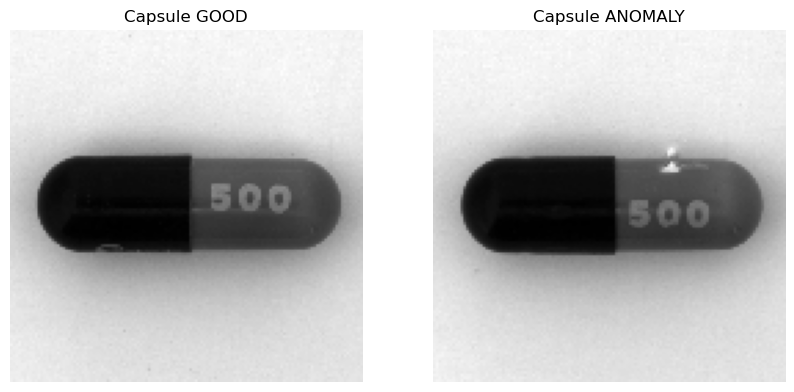

In [3]:
DATASET_PATH = "../data/raw/capsule"
IMG_SIZE = (128, 128) # Final size of images

#### --- LOADING TRAINING DATA --- ####
train_path = os.path.join(DATASET_PATH, "train", "good")
X_train, y_train = process_images(train_path, label=0, img_size=IMG_SIZE)

#### --- LOADING TEST DATA --- ####
test_root_path = os.path.join(DATASET_PATH, "test")
subfolders = os.listdir(test_root_path)

X_test = []
y_test = []

for folder in subfolders:
    folder_path = os.path.join(test_root_path, folder)

    label = 0 if folder == "good" else 1    # Label 1 is for any anomaly

    images, labels = process_images(folder_path, label=label, img_size=IMG_SIZE)

    X_test.extend(images)
    y_test.extend(labels)

# Convert into numpy arrays:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

print("\n Sample images after processing:")

# Show sample images:
plt.figure(figsize=(10, 5))

# GOOD image:
plt.subplot(1, 2, 1)
plt.imshow(X_train[0], cmap='gray')
plt.title("Capsule GOOD")
plt.axis('off')

# ANOMALY image: 
anomaly_idx = np.where(y_test == 1)[0][2] # ndex of anomaly 

plt.subplot(1, 2, 2)
plt.imshow(X_test[anomaly_idx], cmap='gray')
plt.title("Capsule ANOMALY")
plt.axis('off')

plt.show() 


### HOG (Histogram of Oriented Gradients) Explained

**1. What is it?**
HOG is a feature extraction technique used in computer vision. Instead of looking at the specific color of pixels, it looks at the **direction and intensity of edges** (gradients). It divides the image into small grids and counts how many "lines" point in different directions (vertical, horizontal, diagonal).

**2. Why do we need it here?**
We are using "Classic Machine Learning" (like Isolation Forest), not Deep Learning.
* **Raw pixels are too noisy:** A slight change in lighting or position changes every pixel value, confusing the model.
* **Dimensionality:** A 128x128 image has 16,384 features. Raw pixels are inefficient.
* **HOG extracts structure:** It converts the image into a compact numerical vector that describes the **shape and texture**, which is what matters for detecting defects.

**3. How it applies to Capsules:**
* **Normal Capsule:** Has smooth curves and consistent printed text. HOG generates a predictable pattern of gradients.
* **Defective Capsule (Crack/Scratch):** A crack creates a sharp, jagged edge where there should be a smooth surface. HOG detects this **sudden change in gradient intensity and direction**, creating a numerical "scar" in the data vector that the Anomaly Detection model can easily flag.

In [4]:
from skimage.feature import hog
from skimage import exposure

In [5]:
def extract_hog_features(images):
    """Takes a list/array of images and returns their HOG features.
        Args:
            - images: list/array of images (2D arrays)
            
        Returns:
            - hog_features: array of HOG features for each image
            - hog_images: array of HOG images for visualization
    """
    hog_features = []
    hog_images = []

    print("Extracting HOG Features...")

    for image in images:
        feat, hog_image = hog(
            image,
            orientations=9, # Edge directions
            pixels_per_cell=(8, 8), # Size of the grid
            cells_per_block=(2, 2), # Block normalization
            visualize=True,
            block_norm='L2-Hys'
        )

        hog_features.append(feat)
        hog_images.append(hog_image)

    return np.array(hog_features), np.array(hog_images)

In [6]:
#### --- APPLY HOG TO THE DATASET --- ####
X_train_hog, X_train_hog_imgs = extract_hog_features(X_train)
X_test_hog, X_test_hog_imgs = extract_hog_features(X_test)

print(f"\n --- EXTRACTION RESULT ---")
print(f"Original image: {IMG_SIZE} pixels")
print(f"HOG Feature Vector: {X_train_hog.shape[1]} numerical values")

Extracting HOG Features...
Extracting HOG Features...

 --- EXTRACTION RESULT ---
Original image: (128, 128) pixels
HOG Feature Vector: 8100 numerical values


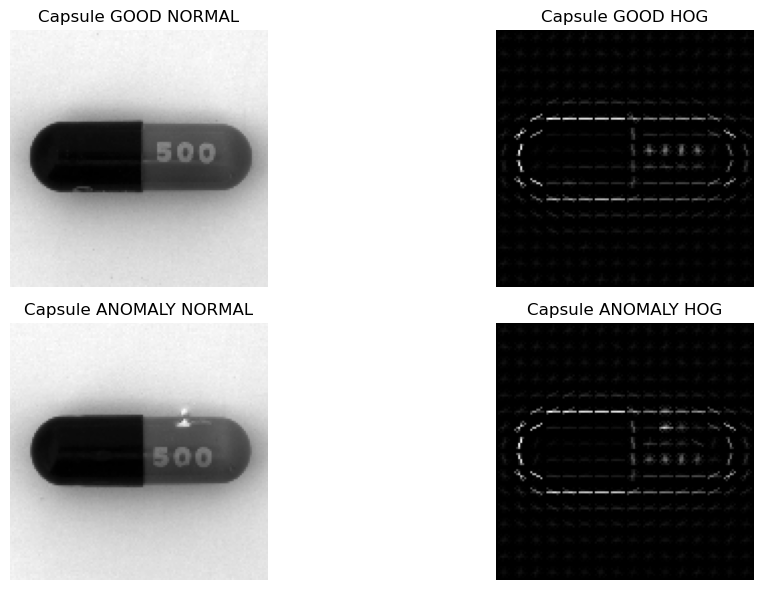

In [7]:
#### --- VISUALIZE HOG --- ####
plt.figure(figsize=(12, 6))

# ANOMALY image index: 
anomaly_idx = np.where(y_test == 1)[0][2] # Index of anomaly image

# GOOD image normal:
plt.subplot(2, 2, 1)
plt.imshow(X_train[0], cmap='gray')
plt.title("Capsule GOOD NORMAL")
plt.axis('off')

# GOOD image HOG:
plt.subplot(2, 2, 2)
plt.imshow(X_train_hog_imgs[0], cmap='gray')
plt.title("Capsule GOOD HOG")
plt.axis('off')

# ANOMALY image normal:
plt.subplot(2, 2, 3)
plt.imshow(X_test[anomaly_idx], cmap='gray')
plt.title("Capsule ANOMALY NORMAL")
plt.axis('off')

# ANOMALY image HOG:
plt.subplot(2, 2, 4)
plt.imshow(X_test_hog_imgs[anomaly_idx], cmap='gray')
plt.title("Capsule ANOMALY HOG")
plt.axis('off')

plt.tight_layout()
plt.show()

### PCA Reconstruction Error: Model Description

**1. What is it?**
Principal Component Analysis (PCA) is traditionally used for dimensionality reduction. However, in the context of **Anomaly Detection**, it is used as a **reconstruction-based model**. The core idea is that a PCA model trained only on "Normal" data learns to compress and reconstruct normal patterns efficiently, but fails to reconstruct anomalies accurately.

**2. How does it work?**
* **Compression (Encoding):** The model projects the high-dimensional input data (HOG features) into a lower-dimensional space using the principal components that capture the most variance of the "Good" capsules.
* **Reconstruction (Decoding):** The model attempts to reconstruct the original data back from this compressed representation.
* **The Anomaly Score:** The system calculates the **Reconstruction Error** (usually Mean Squared Error) between the original input and the reconstructed output.
    * **Normal Capsule:** The error is low because the PCA components capture its structure well.
    * **Defective Capsule:** The defect (e.g., a crack) represents "variance" that was never seen during training. PCA drops this information during compression, so the reconstruction fails to reproduce the defect, resulting in a **high reconstruction error**.

**3. Why use it for MVTec Capsules?**
* **Global Structure Sensitivity:** PCA captures the global correlation of the HOG features. Since capsules are rigid objects with a fixed structure, PCA creates a very strong model of what a "valid" capsule shape looks like.
* **Sensitivity to Breaks:** Defects like cracks or large scratches break the global correlations of the image gradients. PCA is particularly bad at reconstructing these "outlier" features, making the error signal very strong and distinct for detection.

In [8]:
from sklearn.base import BaseEstimator, OutlierMixin
from sklearn.decomposition import PCA

#### --- MODEL PCA RECONSTRUCTION ERROR --- ####
class PCADetector(BaseEstimator, OutlierMixin): # Sklearn-anomaly-detection model
    def __init__(self, n_components=None, threshold=None):
        self.n_components = n_components
        self.threshold = threshold #  Best threshold
        self.pca = None

    def fit(self, X, y=None): # Standard PCA trained already
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(X)

        return self
    
    def decision_function(self, X):
        X_reduced = self.pca.transform(X) # ENCODING
        X_reconstructed = self.pca.inverse_transform(X_reduced) # DECODING

        # High score = GOOD | Low score = ANOMALY
        reconstruction_error = np.mean((X - X_reconstructed) **2, axis=1) # MSE

        return -reconstruction_error # Inverse logic: (return negative)
    
    def predict(self, X):
        # Get raw scores:
        scores = self.decision_function(X)

        if self.threshold is not None:
            
            return np.where(scores < self.threshold, 1, 0)
        
        return scores

In [9]:
#### --- PARAMTERS --- ####
MLFLOW_TRACKING = True
EXPERIMENT_NAME = "Anomaly_capsule_detection"
RUN_NAME = "Try: Base-Line (PCA-RE model)"
SAVE_MODEL_TO_MLFLOW = True

if SAVE_MODEL_TO_MLFLOW:
    RUN_NAME = RUN_NAME
else:
    RUN_NAME = f"{RUN_NAME} - NO model saved"

# Hyperparameters:
HP_MODEL_NAME = "pca_reconstruction"
HP_FEATURES = "HOG"
HP_PCA_VARIANCE = 0.95 # Keep 95% percent of information in PCA
HP_TARGET_RECALL = 0.98

In [10]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def plot_3d():
    ##### --- 3D PIPELINE --- ###
    tsne_pipeline_3d = Pipeline([
        ('scaler', StandardScaler()),
        ('pca_reduce', PCA(n_components=50)), 
        ('tsne', TSNE(n_components=3,        
                    perplexity=30, 
                    random_state=42, 
                    n_jobs=-1))
    ])

    #### --- PREPARE DATA FOR VISUALIZATION --- ####
    X_all = np.concatenate([X_train_hog, X_test_hog], axis=0)
    y_all = np.concatenate([np.zeros(len(X_train_hog)), y_test], axis=0)

    X_embedded_3d = tsne_pipeline_3d.fit_transform(X_all)

    df_tsne_3d = pd.DataFrame(X_embedded_3d, columns=['Dim 1', 'Dim 2', 'Dim 3'])
    df_tsne_3d['Label'] = y_all
    df_tsne_3d['Label'] = df_tsne_3d['Label'].map({0: 'GOOD', 1: 'ANOMALY'})

    #### --- 3D GRAPH PLOT --- ####
    print("Generando gráfico 3D interactivo...")

    fig = px.scatter_3d(
        df_tsne_3d, 
        x='Dim 1', 
        y='Dim 2', 
        z='Dim 3',
        color='Label',
        color_discrete_map={'GOOD': 'blue', 'ANOMALY': 'red'},
        title="tSNE Data Visualization: MVTec - Capsule Dataset",
        width=1000,
        height=800
    )

    fig.update_traces(
        marker=dict(
            size=6,       
            opacity=0.8, 
            line=dict(width=0.5, color='DarkSlateGrey')
        )
    )

    fig.update_layout(
        font=dict(size=14),
        
        scene=dict(
            xaxis=dict(title_font=dict(size=18)),
            yaxis=dict(title_font=dict(size=18)),
            zaxis=dict(title_font=dict(size=18)),
        ),
        
        legend=dict(
            font=dict(size=16),
            title_font=dict(size=18)
        )
    )

    fig.show()

    return fig


 --- TRAINING THE MODEL: pca_reconstruction ---
PCA got 196 components to get a variance of 95.0%

 --- OPTIMIZING MODEL ---
Target recall found
Suggested threshold: -0.7855
Training finished.
Recording parameters to MLFlow...

 --- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.67      0.26      0.38        23
           1       0.86      0.97      0.91       109

    accuracy                           0.85       132
   macro avg       0.76      0.62      0.64       132
weighted avg       0.83      0.85      0.82       132

ROC-AUC Score: 0.8440
Recording metrics to MLFlow...


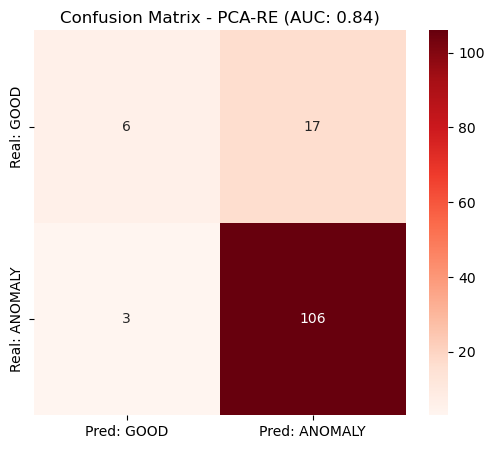

Generando gráfico 3D interactivo...


2025/11/23 20:43:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Saving model to MLFlow...


2025/11/23 20:43:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

#### --- INIT MLFLOW SERVICE --- ####
if MLFLOW_TRACKING:

    mlflow.set_experiment(EXPERIMENT_NAME)

    with mlflow.start_run(run_name=RUN_NAME):

        #### --- TRAIN MODEL --- ####
        print(f"\n --- TRAINING THE MODEL: {HP_MODEL_NAME} ---")
        
        # Escaling the data:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_hog)
        X_test_scaled = scaler.transform(X_test_hog) 
        
        # Instantiate the model:
        pca_re_model = PCADetector(n_components=HP_PCA_VARIANCE)
        pca_re_model.fit(X_train_scaled)

        # Get components:
        n_components = pca_re_model.pca.n_components_
        print(f"PCA got {n_components} components to get a variance of {HP_PCA_VARIANCE*100}%")


        #### --- TUNING THRESHOLD --- ####
        print("\n --- OPTIMIZING MODEL ---")
        test_scores = pca_re_model.decision_function(X_test_scaled)
        _, recall, thresholds = precision_recall_curve(y_test, -test_scores)

        # Look for the target threshold:
        try:
            idx = np.where(recall > HP_TARGET_RECALL)[0][-1]
            best_threshold = -thresholds[idx]
            print("Target recall found")

        except IndexError:
            idx = np.argmax(recall) # If target recall not found
            best_threshold = -thresholds[idx]
            print("Target recall NOT found")

        print(f"Suggested threshold: {best_threshold:.4f}")
        print("Training finished.")

        print("Recording parameters to MLFlow...")
        params_to_log = {
            'model_name': HP_MODEL_NAME,
            'features': HP_FEATURES,
            'pca_variance': HP_PCA_VARIANCE,
            'target_recall': HP_TARGET_RECALL,
            'optimal_treshold': best_threshold
        }
        mlflow.log_params(params_to_log)


        #### --- OPTIMIZE MODEL TO PREDICT --- ####
        pca_re_model.threshold = best_threshold


        #### --- PREDICT TEST SET --- ####
        y_pred = pca_re_model.predict(X_test_scaled)


        #### --- CLASSIFICATION REPORT --- ####
        print("\n --- CLASSIFICATION REPORT ---")
        report = classification_report(y_test, y_pred)
        report_dict = classification_report(y_test, y_pred, output_dict=True)
        print(report)

        anomaly_scores = pca_re_model.decision_function(X_test_scaled)
        auc_score = roc_auc_score(y_test, -anomaly_scores)
        print(f"ROC-AUC Score: {auc_score:.4f}")

        # Record metrics to MLFlow:
        print("Recording metrics to MLFlow...")
        metrics_to_log = {
            "accuracy": report_dict["accuracy"],
            "macro_avg_f1": report_dict["macro avg"]["f1-score"],
            "anomaly_recall": report_dict['1']['recall'],     
            "anomaly_precision": report_dict['1']['precision'],
            "anomaly_f1": report_dict['1']['f1-score'],
            "good_recall": report_dict['0']['recall'],
            "roc_auc": auc_score
        }
        mlflow.log_metrics(metrics_to_log)


        #### --- CONFUSION MATRIX --- ###
        cm = confusion_matrix(y_test, y_pred)
        fig_cm, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Pred: GOOD', 'Pred: ANOMALY'],
            yticklabels=['Real: GOOD', 'Real: ANOMALY'], ax=ax)
            
        ax.set_title(f"Confusion Matrix - PCA-RE (AUC: {auc_score:.2f})")
        
        # Temp file to save confusion matrix:
        cm_temp_path = "../reports/figures/cm_isolation_forest.png"
        fig_cm.savefig(cm_temp_path)
        mlflow.log_artifact(cm_temp_path) # Record in MLFlow
        os.remove(cm_temp_path)
        
        plt.show()
        plt.close()

        # Save the 3D figure:
        fig_3d = plot_3d()
        mlflow.log_figure(fig_3d, artifact_file='data_3d_distribution.html')


        #### --- SAVE MODEL --- ####
        if SAVE_MODEL_TO_MLFLOW:
            print("Saving model to MLFlow...")
            # Guardamos el Pipeline completo (Scaler + Modelo) para producción
            pipeline_final = Pipeline([
                ('scaler', scaler),
                ('pca_detector', pca_re_model)
            ])

            mlflow.sklearn.log_model(pipeline_final, "pca_reconstruction_model_tuned")
            print("Model saved.")

